This algorithm is to provide the sensitivity of different attributes depending on a user. The current attributes are sleep hours, exercise hours, and calories you gain. Because of lack of dataset, this ML framework uses the daily data the user provides us. Based on the dataset, this framework solves a multivariate regression problem. Using this regression problem, the framework solves tayler series expansion to gain the sensitivity depending on an attributes.


In [1]:
#Load python packages
import pandas as pd
import json
import numpy as np
import sys
import matplotlib.pyplot as plt
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR
import sys
import seaborn as sns


In [2]:
#############################################
# Input parameters
#############################################
SENSITIVITY_RATIO = 0.3
MAXIMUM_NUM_DATA = 30 #DAYS
SAMPLING_TIME = 1 #DAY


In [3]:
##############################################
# Read dataset
##############################################
#TODO: This one should be from the SQL database
df = pd.read_csv('weight.csv')

In [4]:
##############################################
# DATA EXPLORATION
##############################################
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

columns=['Sleep', 'Exercise', 'Calories','Weight']
df_data = df.copy()
df_data = df_data[columns]

In [5]:
##############################################
# Data manupulation for NAN value
##############################################
cols = df_data.columns

nan_columns = df_data.isnull().any()
nan_true = [i for i, col_i in enumerate(nan_columns) if col_i == True]

#Should be forloop
for nan_i in nan_true:
    column_name = nan_columns.index[nan_i]
    s = pd.Series(df_data[column_name])
    df_data[column_name] = s.interpolate(method='nearest')


In [6]:
# Use only n number of data
df_data = df_data.iloc[-MAXIMUM_NUM_DATA:]

In [7]:
##############################################
#  ARIMA stands for Auto-Regressive Integrated Moving Average.
##############################################

Y = df_data['Weight']
X = df_data.drop(['Weight'], axis=1)

#creating the train and validation set
train = df_data[:-1]
test = df_data[-1:]

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=1)

#make final predictions
model = VAR(endog=train)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Sensivity analysis uses taylor series expansion. Let's say the prediction model from the multi-variate regression is $ \hat{f} (\mathbf{x}) $. 
$$\hat{f}(\mathbf{x} + \delta(\mathbf{x})) = \hat{f}(\mathbf{x}) + \hat{{f}
'}(\mathbf{x})\delta\mathbf{x} + high \: order \:terms$$ 
When $\delta{x}$ is small, we can neglect the high order terms, and define the first or higher order of approximated functions. In here, we only consider the first order model, which is a linear model.
        $$\hat{f}(\mathbf{x} + \delta(\mathbf{x})) = \hat{f}(\mathbf{x}) + \hat{{f}'}(\mathbf{x})\delta\mathbf{x} + \varepsilon (\mathbf{\delta}^2) \approx \hat{f}(\mathbf{x}) + \hat{{f}'}(\mathbf{x})\delta\mathbf{x} $$ 
From the Taylor series expansion, we can get the gradient information.
$$ \hat{{f}'}(\mathbf{x})  = \frac{\hat{f}(\mathbf{x} + \delta\mathbf{x}) - \hat{f}(\mathbf{x})}{\delta\mathbf{x}} $$
This gradient can be computed by the numerically through the small perturbation $\delta{x}$

In [8]:
##############################################
#  Sensitivity
##############################################
def sensitivity(df, col_name, ratio, percentage=0.9):
    print(col_name)
    avg_data = df_data_sen.mean()
    # df_data_sen[col_name]
    df_data_sen[col_name].iloc[-2]= df_data_sen[col_name].iloc[-2] * ratio

    train = df_data_sen[:-1]
    test = df_data_sen[-1:]

    model_sen = VAR(endog=train)
    model_sen_fit = model_sen.fit()

    # make prediction on validation
    yhat_sen_cal = model_sen_fit.forecast(model_sen_fit.y, steps=2)
    return yhat_sen_cal[:,3][-1]

In [9]:

col_names_sensitivity = {'Sleep':1+SENSITIVITY_RATIO, 'Exercise':1+SENSITIVITY_RATIO, 'Calories':1-SENSITIVITY_RATIO}

weight_pred = []
weight_sensitivity = []
for col_i, direction in col_names_sensitivity.items():
    df_data_sen = df_data.copy()
    res = sensitivity(df_data_sen, col_i, direction, percentage=0.1)
    weight_pred.append(res)
    weight_sensitivity.append((yhat[1,3] - res)/SAMPLING_TIME)

Sleep
Exercise
Calories


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [10]:

#FINAL RESULT
df_sen = pd.DataFrame()
df_sen['attr'] = col_names_sensitivity.keys()
df_sen['weight_pred'] = weight_pred
df_sen['sensitivity'] = np.array(weight_sensitivity) * -1


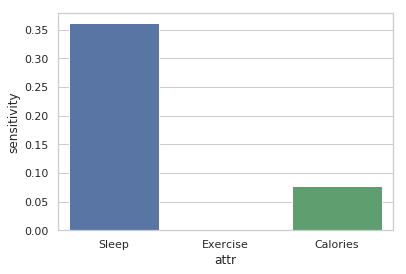

In [11]:
sns.set(style="whitegrid")
ax = sns.barplot(x="attr", y="sensitivity", data=df_sen)
plt.show()
